In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [7]:
class FXBarrierOption:
    def __init__(self, spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level=None, barrier_type=None):
        self.spot_price = spot_price
        self.strike_price = strike_price
        self.time_to_maturity = time_to_maturity
        self.volatility = volatility
        self.domestic_rate = domestic_rate
        self.foreign_rate = foreign_rate
        self.barrier_level = barrier_level
        self.barrier_type = barrier_type



    
    
    def compute_d1(self, spot_price=None):
        spot_price = spot_price or self.spot_price
        return (np.log(spot_price / self.strike_price) +
                (self.domestic_rate - self.foreign_rate + 0.5 * self.volatility ** 2) * self.time_to_maturity) / (self.volatility * np.sqrt(self.time_to_maturity))


    
    def compute_d2(self, d1=None):
        d1 = d1 or self.compute_d1()
        return d1 - self.volatility * np.sqrt(self.time_to_maturity)







    
    def calculate_vanilla_price(self, option_type='call'):
        d1 = self.compute_d1()
        d2 = self.compute_d2(d1)
        if option_type == 'call':
            price = np.exp(-self.foreign_rate * self.time_to_maturity) * self.spot_price * norm.cdf(d1) - \
                    np.exp(-self.domestic_rate * self.time_to_maturity) * self.strike_price * norm.cdf(d2)
        else: #put 
            price = np.exp(-self.domestic_rate * self.time_to_maturity) * self.strike_price * norm.cdf(-d2) - \
                    np.exp(-self.foreign_rate * self.time_to_maturity) * self.spot_price * norm.cdf(-d1)
        return price

    def calculate_barrier_price(self):
        """Simplified barrier pricing for demonstration."""
        if not self.barrier_type or not self.barrier_level:
            raise ValueError("Barrier type and level must be specified for barrier options.")
        if self.barrier_type == 'up-in':
            return self.calculate_vanilla_price('call')  
        elif self.barrier_type == 'up-out':
            return self.calculate_vanilla_price('call') - self._down_and_in_call_price()
        elif self.barrier_type == 'down-in':
            return self._down_and_in_call_price()
        elif self.barrier_type == 'down-out':
            return self.calculate_vanilla_price('call') - self._down_and_in_call_price()
        else:
            raise NotImplementedError(f"Barrier type '{self.barrier_type}' not implemented.")


    
    def _down_and_in_call_price(self):
        d1_in = self.compute_d1(self.barrier_level)
        d2_in = self.compute_d2(d1_in)
        return np.exp(-self.foreign_rate * self.time_to_maturity) * self.barrier_level * norm.cdf(d1_in) - \
               np.exp(-self.domestic_rate * self.time_to_maturity) * self.strike_price * norm.cdf(d2_in)


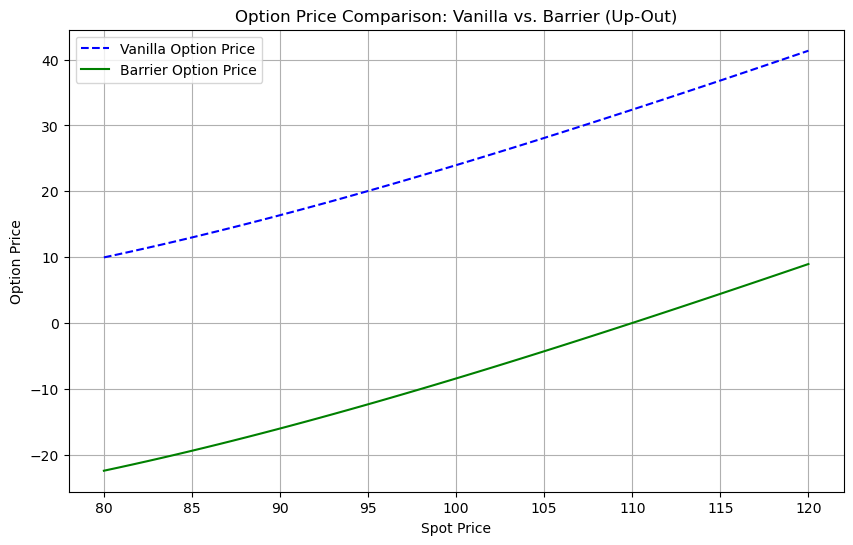

In [19]:
# plotting
def plot_pricing_comparison():
    # random values
    spot_prices = np.linspace(80, 120, 50)
    strike_price = 80
    time_to_maturity = 1
    volatility = 0.3
    domestic_rate = 0.05
    foreign_rate = 0.03
    barrier_level = 110

    # Calculation
    vanilla_prices = []
    barrier_prices = []
    for S in spot_prices:
        option = FXBarrierOption(S, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level, barrier_type='up-out')
        vanilla_prices.append(option.calculate_vanilla_price())
        barrier_prices.append(option.calculate_barrier_price())

    # graph
    plt.figure(figsize=(10, 6))
    plt.plot(spot_prices, vanilla_prices, label="Vanilla Option Price", linestyle='--', color='blue')
    plt.plot(spot_prices, barrier_prices, label="Barrier Option Price", color='green')
    plt.title("Option Price Comparison: Vanilla vs. Barrier (Up-Out)")
    plt.xlabel("Spot Price")
    plt.ylabel("Option Price")
    plt.legend()
    plt.grid()
    plt.show()

# Plot
plot_pricing_comparison()